# RKI Data Manipulation

## Introduction

This notebooks tests the handling of the RKI_History CSV-File (Source: https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/6d78eb3b86ad4466a8e264aa2e32a2e4_0/data?page=17627) with the overall goal of plotting the respective data.

## Preparation
In the first step, we import the RKI Data and do some declarations.

In [19]:
import numpy as np
import pandas as pd


rki=pd.read_csv('RKI_History.csv', sep=',', header='infer')
#rki['Datum']=pd.to_datetime(rki_raw['Datum'])
#rki=rki.sort_values(by='AdmUnitId')
rki=rki.sort_values(by='Datum')

lk=np.array(rki['AdmUnitId'])
lk_comp_num=len(lk)
day=np.array(rki['Datum'])
case=np.array(rki['AnzFallMeldung'])
case_cum=np.array(rki['KumFall'])
rki

,ObjectId,AdmUnitId,BundeslandId,Datum,AnzFallNeu,AnzFallVortag,AnzFallErkrankung,AnzFallMeldung,KumFall
0,1,0,0,2020/03/01 00:00:00+00,0,36,221,11,170
69325,69326,7143,7,2020/03/01 00:00:00+00,0,0,0,0,0
69623,69624,7211,7,2020/03/01 00:00:00+00,0,0,0,0,0
158223,158224,14625,14,2020/03/01 00:00:00+00,0,0,0,0,0
33952,33953,5113,5,2020/03/01 00:00:00+00,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
54001,54002,5974,5,2021/04/15 00:00:00+00,55,0,1,15,7176
82538,82539,8119,8,2021/04/15 00:00:00+00,86,0,0,86,15849
175386,175387,16075,16,2021/04/15 00:00:00+00,29,0,0,9,5285
137444,137445,9779,9,2021/04/15 00:00:00+00,53,0,2,24,4812


Now we import a database that contains population sizes of all Administrative Units. (Source: https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0)

In [20]:
pop=pd.read_csv('RKI_Corona_Landkreise.csv', sep=',', header='infer')
lk_popcalc=np.array(pop['AdmUnitId'])
lk_popsize=np.array(pop['EWZ'])
lk_num=len(lk_popsize)

## Setup for intern calculations
For intern overview and calculations, we set up an array consisting of the RKI Administrative Unit IDs of the LKs in the chosen region.

In [21]:
lk_hildesheim_id=3254
lk_holzminden_id=3255
lk_goslar_id=3153
lk_höxter_id=5762
lk_northeim_id=3155
lk_göttingen_id=3159
lk_harz_id=15085
lk_kassel_id=6633
sk_kassel_id=6611
lk_werrameißnerkreis_id=6636
lk_eichsfeld_id=16061
lk_nordhausen_id=16062

region_ids=[lk_hildesheim_id,lk_holzminden_id,lk_goslar_id,lk_höxter_id,lk_northeim_id,lk_göttingen_id,lk_harz_id,lk_kassel_id,sk_kassel_id,lk_werrameißnerkreis_id,lk_eichsfeld_id,lk_nordhausen_id]
region_num=len(region_ids)
region_names=['Hildesheim','Holzminden','Goslar', 'Höxter','Northeim','Göttingen','Harz','Kassel (Land)','Kassel (Stadt)', 'Werra-Meißner-Kreis','Eichsfeld','Nordhausen']

We now find out the number of documented time steps:

In [22]:
time=0
for i in lk:
    if i==0:
        time+=1

This is a function that evaluates the 7-day-incidence (per 100,000 inhabitants) in a single cell using a given array of infections over time and the population size:

In [23]:
def seven_day_incidence(case_array,pop):
    output=np.zeros((len(case_array)))
    for i in range(len(case_array)):
        if(i>=6):
            isum=0
            for j in range(7):
                isum+=case_array[i-j]
            output[i]=isum/pop
        else:
            output[i]=0 #or undefined, not sure tbh
    return 100000*output

The following cell contains the main work, namely transferring the data from several (mixed-up) position in multiple source into one array that is easy to cope with and only includes the information on the regarded region.

In [24]:
dimensions=3 #here: new cases, cumulative cases, 7-day-incidence
region_cases=np.zeros((region_num,dimensions, time))
region_popsize=np.zeros((region_num))

for intern_region_number in range(region_num):
    current_time=0
    for i in range(lk_comp_num):
        if lk[i]==region_ids[intern_region_number]:
            region_cases[intern_region_number][0][current_time]=case[i]
            region_cases[intern_region_number][1][current_time]=case_cum[i]
            current_time+=1
    for j in range(lk_num):
        if lk_popcalc[j]==region_ids[intern_region_number]:
            region_popsize[intern_region_number]=lk_popsize[j]
    region_cases[intern_region_number][2]=seven_day_incidence(region_cases[intern_region_number][0],region_popsize[intern_region_number])


Now, we can easily plot e.g. 

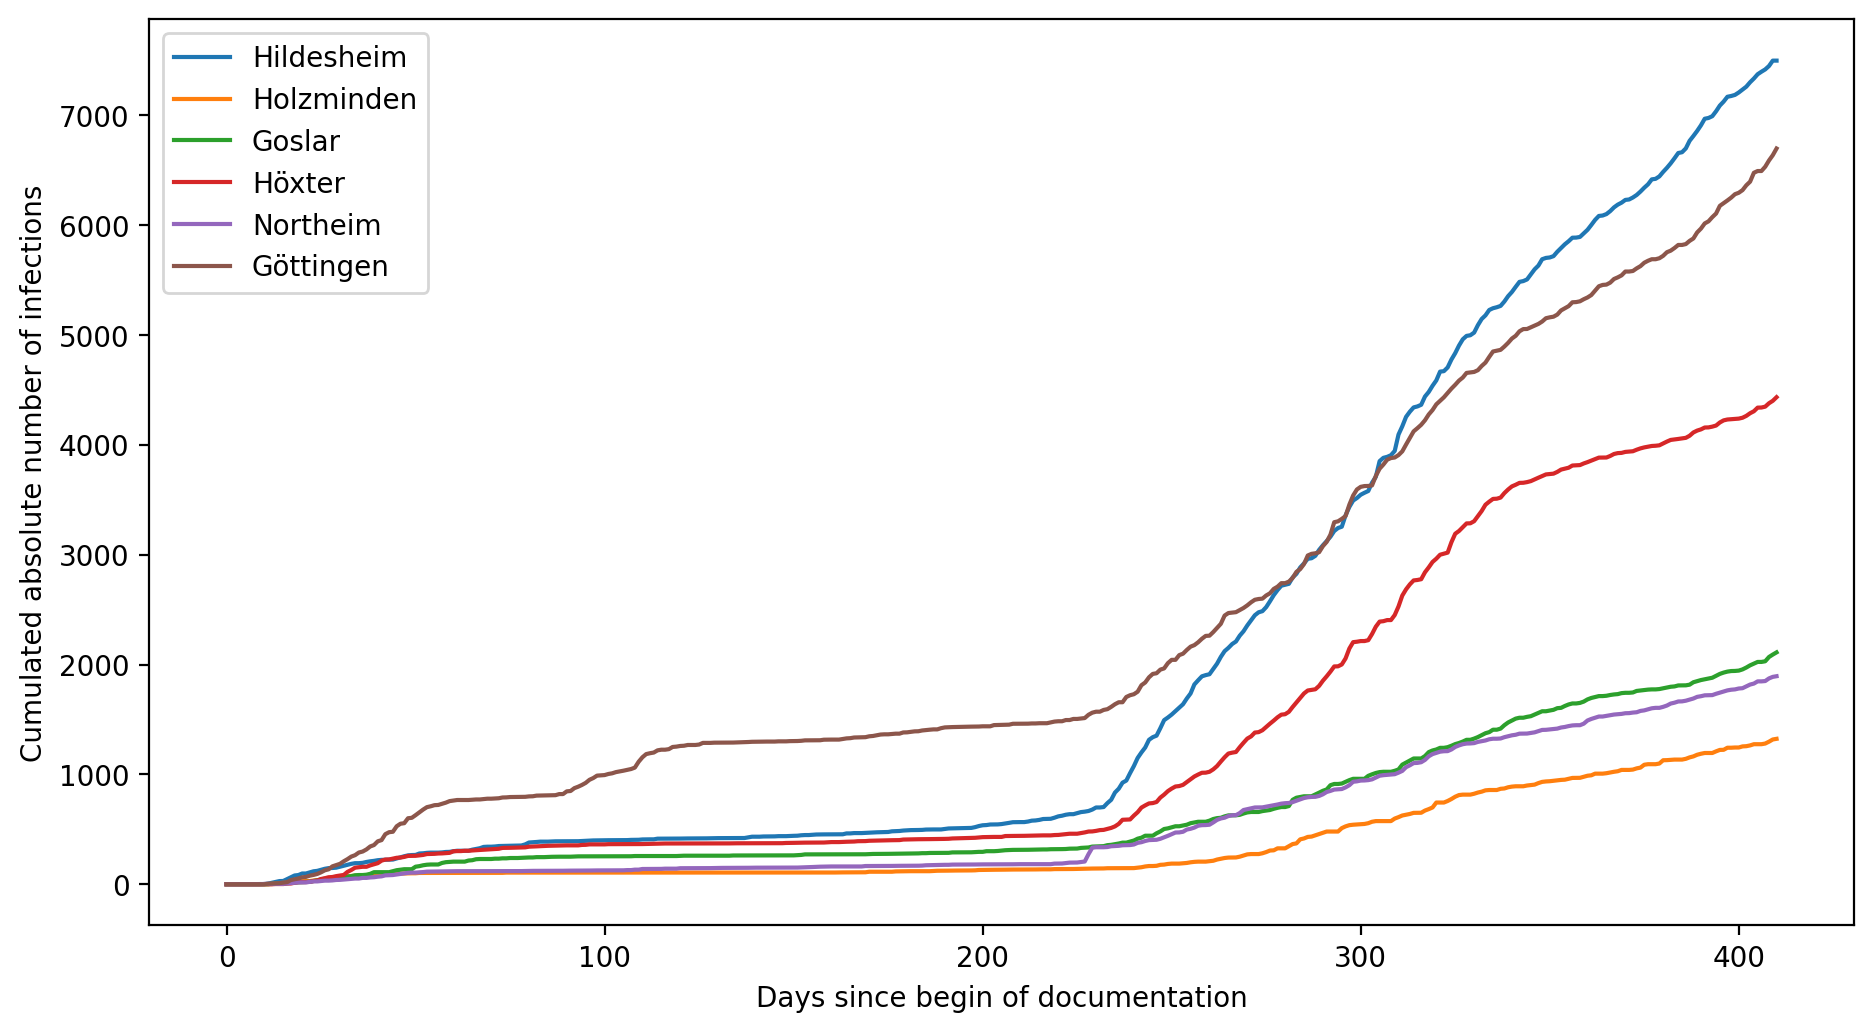

In [25]:
import matplotlib.pyplot as plt

show_num=6

plt.figure(figsize=(11,6), dpi=200)
plt.xlabel('Days since begin of documentation')
plt.ylabel('Cumulated absolute number of infections')
for p in range(show_num):
    plt.plot(range(time),region_cases[p][1],label=region_names[p])
plt.legend()
plt.show()

We can also plot examples of the 7-day-incidence.

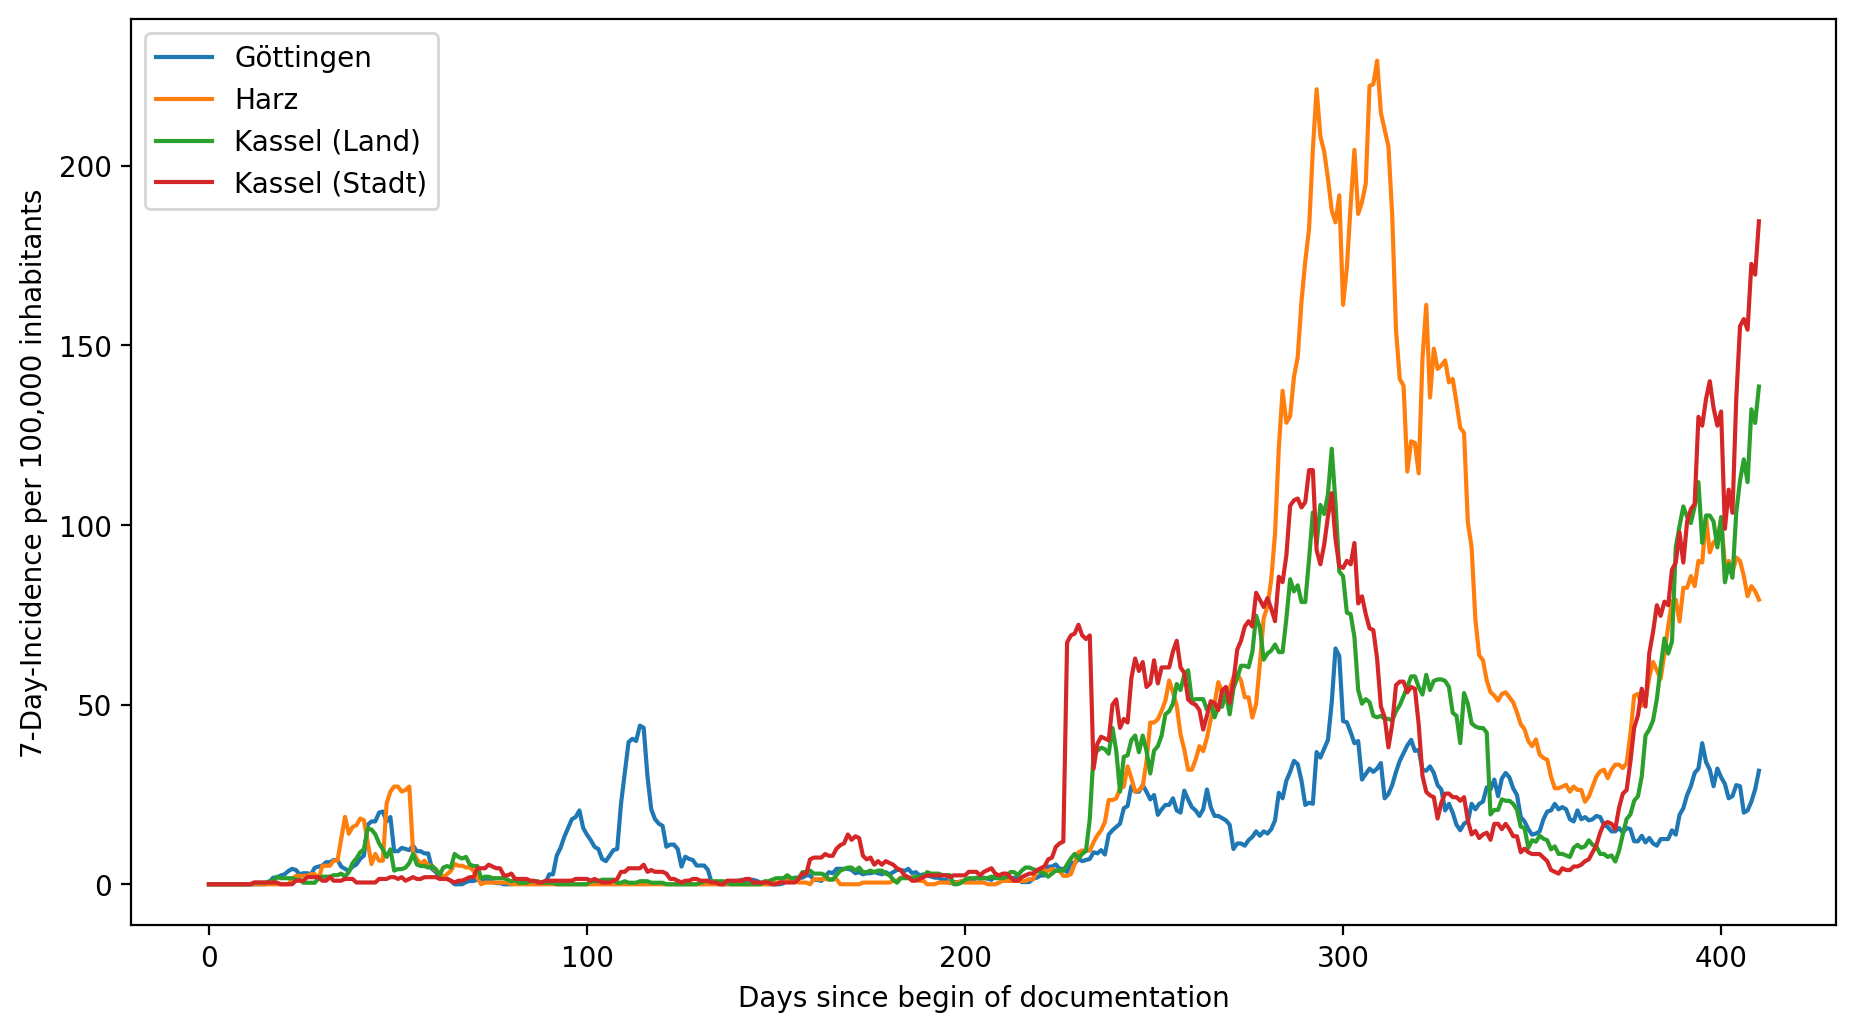

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,6), dpi=200)
plt.xlabel('Days since begin of documentation')
plt.ylabel('7-Day-Incidence per 100,000 inhabitants')
for p in [5,6,7,8]:
    plt.plot(range(time),region_cases[p][2],label=region_names[p])
plt.legend(loc='upper left')
plt.show()

Using the code from previous notebooks, the graph of the regarded region can easily be constructed.

In [27]:
import networkx as nx

g11_laplace=np.array([[3,-1,-1,0,-1,0,0,0,0,0,0,0],
             [-1,3,0,-1,-1,0,0,0,0,0,0,0],
             [-1,0,5,0,-1,-1,-1,0,0,0,0,-1],
             [0,-1,0,2,0,0,0,-1,0,0,0,0],
             [-1,-1,-1,0,6,-1,-1,-1,0,0,0,0],
             [0,0,-1,0,-1,7,0,-1,-1,-1,-1,-1],
             [0,0,-1,0,0,0,2,0,0,0,0,-1],
             [0,0,0,-1,-1,-1,0,5,-1,-1,0,0],
             [0,0,0,0,0,-1,0,-1,2,0,0,0],
             [0,0,0,0,0,-1,0,-1,0,3,-1,0],
             [0,0,0,0,0,-1,0,0,0,-1,3,-1],
             [0,0,-1,0,0,-1,-1,0,0,0,-1,4]])

def adjacence(lap):
    adj=-lap
    dimension=len(adj[1])
    for i in range(dimension):
        adj[i][i]=0
    return adj

g11_adjacence=adjacence(g11_laplace)


def makegraph(matrix):
    G = nx.DiGraph()
    dim=len(matrix[0])
    for i in range(dim): 
        for j in range(dim): 
            if matrix[i][j] == 1: 
                G.add_edge(i,j)
    return G

G1=makegraph(g11_adjacence)

distinct_pos = nx.random_layout(G1, seed=34)
pos = nx.spring_layout(G1, pos=distinct_pos)

In the next step, we set up the colorbar and the plot function that starts plotting the state 100 days ago.

In [28]:
ccm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin = 0, vmax=0.07))
ccm._A = []  
    
def plot_cstate(animation_time):
    cmap=[]
    for node in G1:
        cmap.append(region_cases[node][1][time-100+animation_time])
    q=nx.draw_networkx(G1,pos,node_size=2000, with_labels=True, font_color='black', node_color=cmap/region_popsize ,cmap=plt.cm.Reds,vmin=0, vmax=0.07)
    return q

First, we can plot one state as an example.

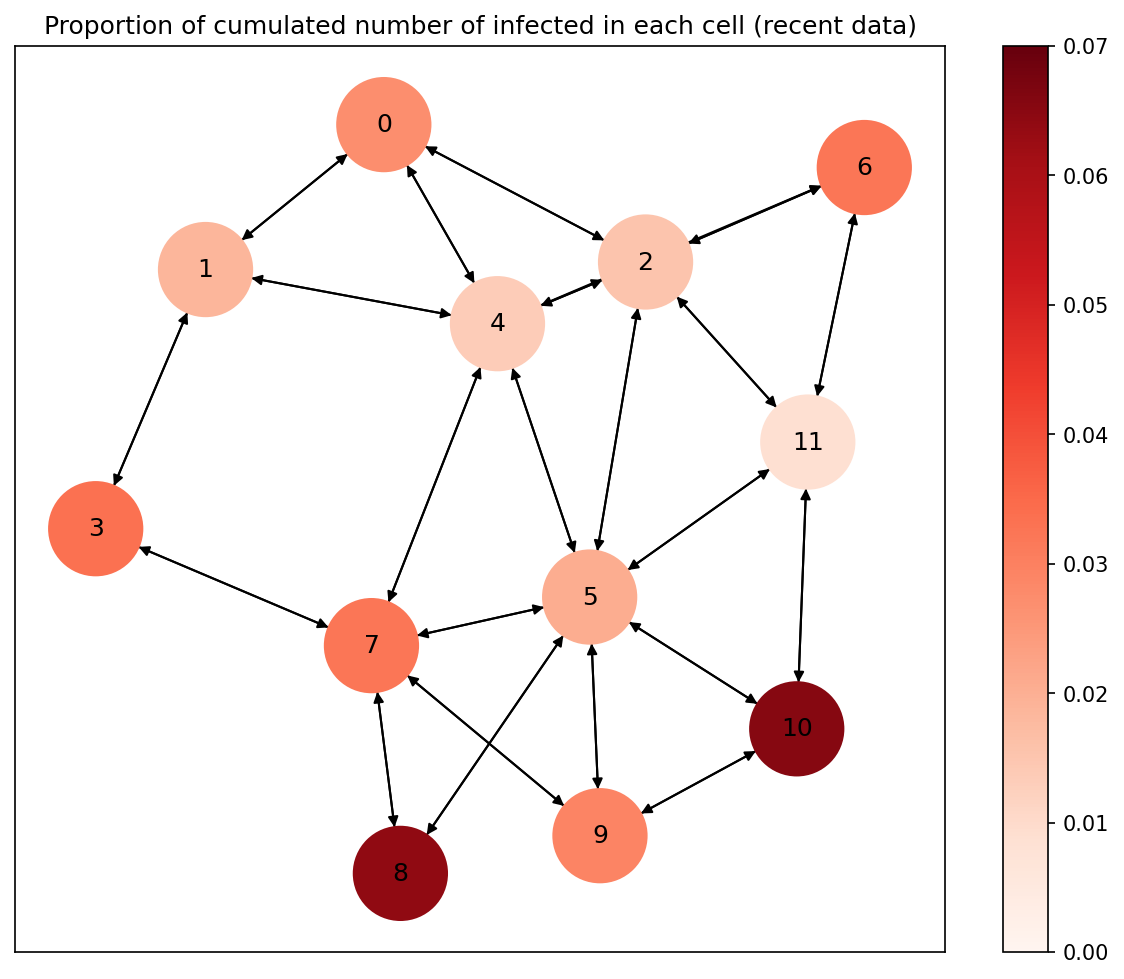

In [29]:
plt.figure(figsize=(10,8), dpi=150)
plt.title('Proportion of cumulated number of infected in each cell (recent data)')
plot_cstate(99)
plt.colorbar(ccm) 
plt.show()

Finally, we can once again assemble an animation: (result is not very interesting)

In [30]:
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import math

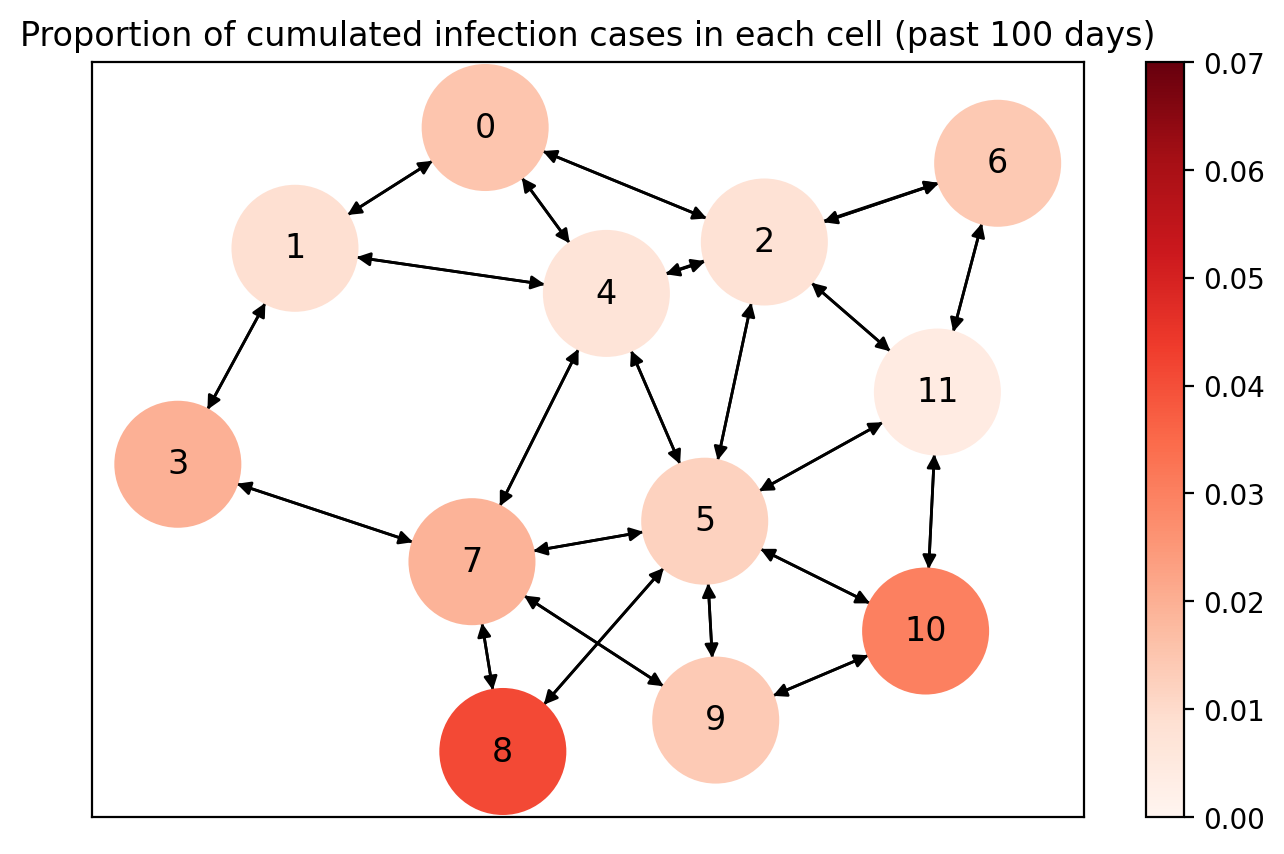

In [31]:
frame_setting=100
interval_setting=math.floor(10000/frame_setting)

plt.figure(figsize=(8,5),dpi=200)
plt.title('Proportion of cumulated infection cases in each cell (past 100 days)')
plt.colorbar(ccm)
ani1 = animation.FuncAnimation(plt.gcf(), plot_cstate,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=1000)
#HTML(ani1.to_html5_video())

We can also animate 7-day-incidences: (result is very interesting)

In [32]:
sdm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin = 0, vmax=250))
sdm._A = []  
    
def plot_sdstate(animation_time):
    sdmap=[]
    for node in G1:
        sdmap.append(region_cases[node][2][2*animation_time])
    q=nx.draw_networkx(G1,pos,node_size=2000, with_labels=True, font_color='black', node_color=sdmap ,cmap=plt.cm.Reds,vmin=0, vmax=250)
    return q

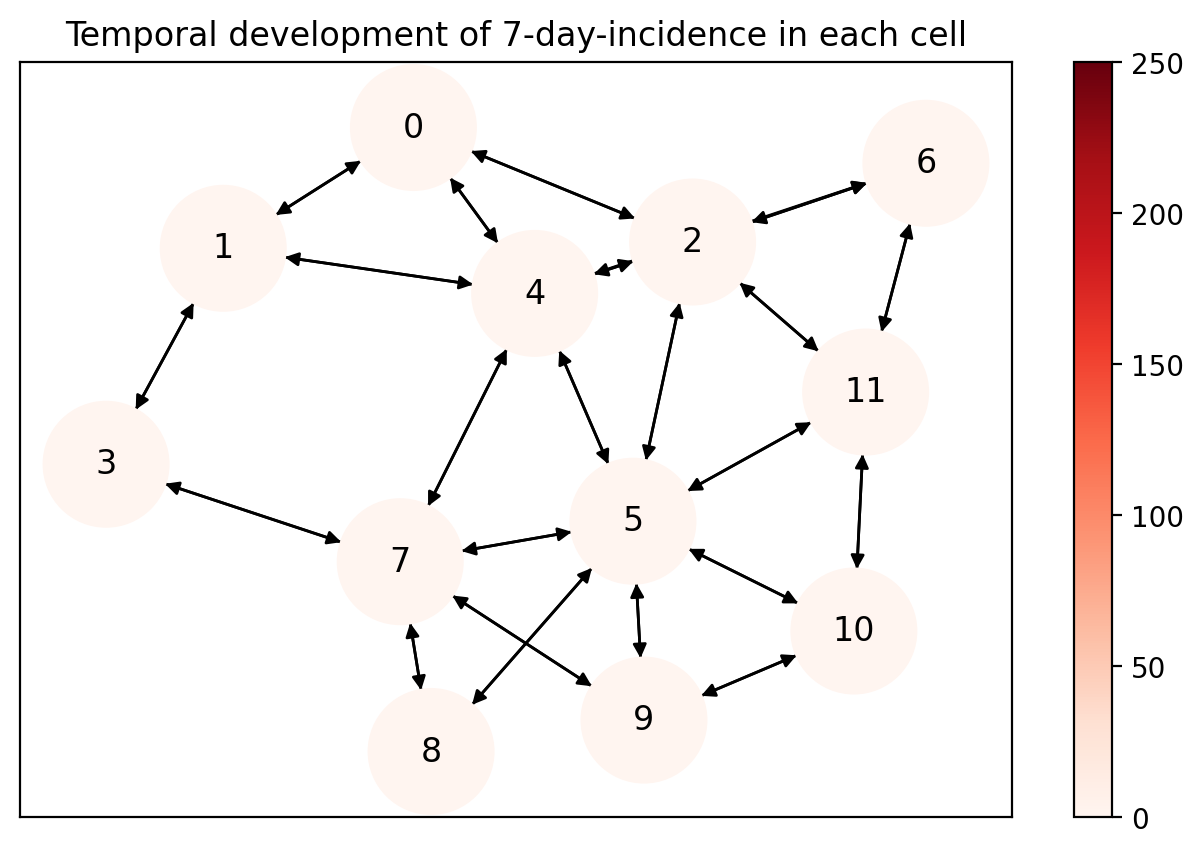

In [33]:
frame_setting=math.floor(time/2)
interval_setting=math.floor(20000/frame_setting)

plt.figure(figsize=(8,5),dpi=200)
plt.title('Temporal development of 7-day-incidence in each cell')
plt.colorbar(sdm)
ani1 = animation.FuncAnimation(plt.gcf(), plot_sdstate,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=1000)
#HTML(ani1.to_html5_video())